<a href="https://colab.research.google.com/github/sami24191/Data-Visualization/blob/master/Time_Series_Forecasting_PJME_20240526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')

In [2]:
# upload data file

from google.colab import files
uploaded = files.upload()

Saving PJME_hourly.csv to PJME_hourly.csv


In [25]:

import io
df = pd.read_csv(io.BytesIO(uploaded['PJME_hourly.csv']))
df.head(1)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0


In [26]:

df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

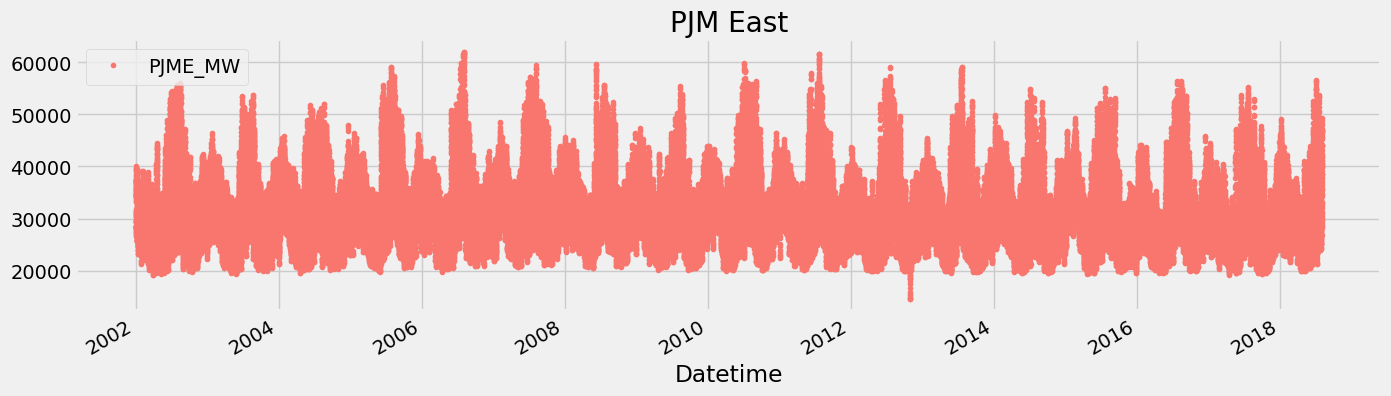

In [19]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,4), color=color_pal[0], title='PJM East')

## **Train/Test Split**

Cut off the data after 2015 to use as our validation set.

In [38]:
split_date = '01-Jan-2015'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [39]:
_ = test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(14,4), title='PJM East', style='.')

ValueError: columns overlap but no suffix specified: Index(['date', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth'],
      dtype='object')

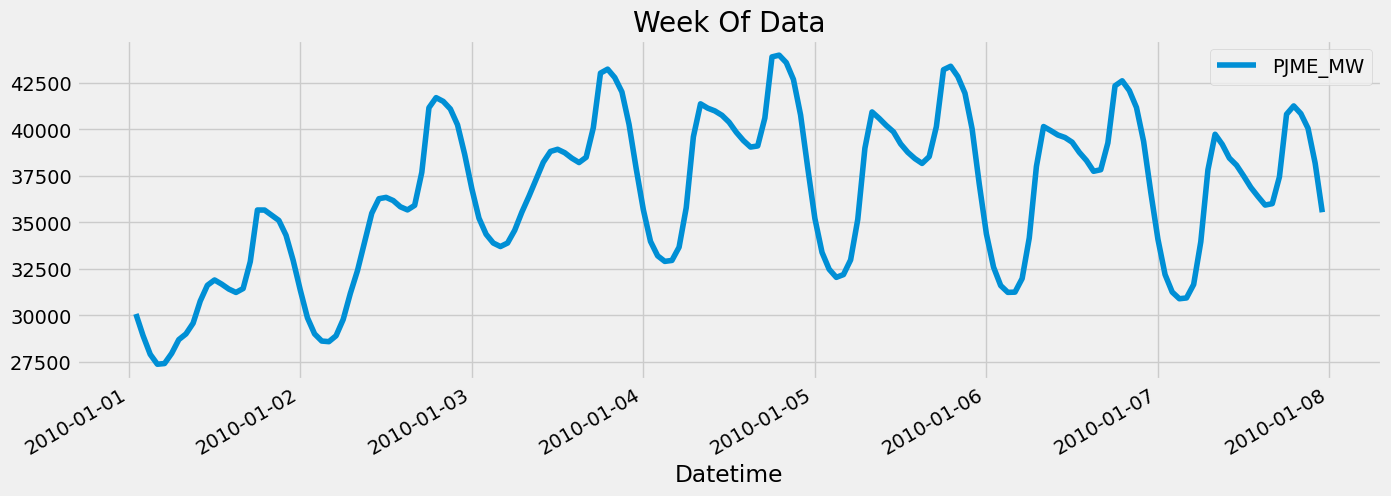

In [29]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Create Time Series Features

In [31]:

# 1. Following function takes a DataFrame `df` and an optional `label` parameter.
# 2. It creates a new column `'date'` in the DataFrame, which is a copy of the index (assuming the index is a datetime index).
# 3. Then, it creates several new columns in the DataFrame, each representing a different time-based feature derived from the `'date'` column
# 4. The function then creates a new DataFrame `X` containing only the time-based feature columns mentioned above.
# 5. If a `label` is provided, it creates a Series `y` containing the values from the column specified by `label`.
# 6. If `label` is provided, the function returns `X` (the features) and `y` (the label). If `label` is not provided, it returns only `X`.

# This function is useful for preparing data for time series analysis or machine learning tasks, where the temporal features derived from the datetime index can be used as input features. The time-based features can help capture patterns and relationships related to time, such as daily, weekly, or seasonal trends.


def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear

    # X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth']] #,'weekofyear'
    # if label:
    #     y = df[label]
    #     return X, y
    return df

In [32]:
df = create_features(df)
df

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,1,1,2018,1,1
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,1,1,2018,1,1
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,1,1,2018,1,1


## Feature / Target Relationship

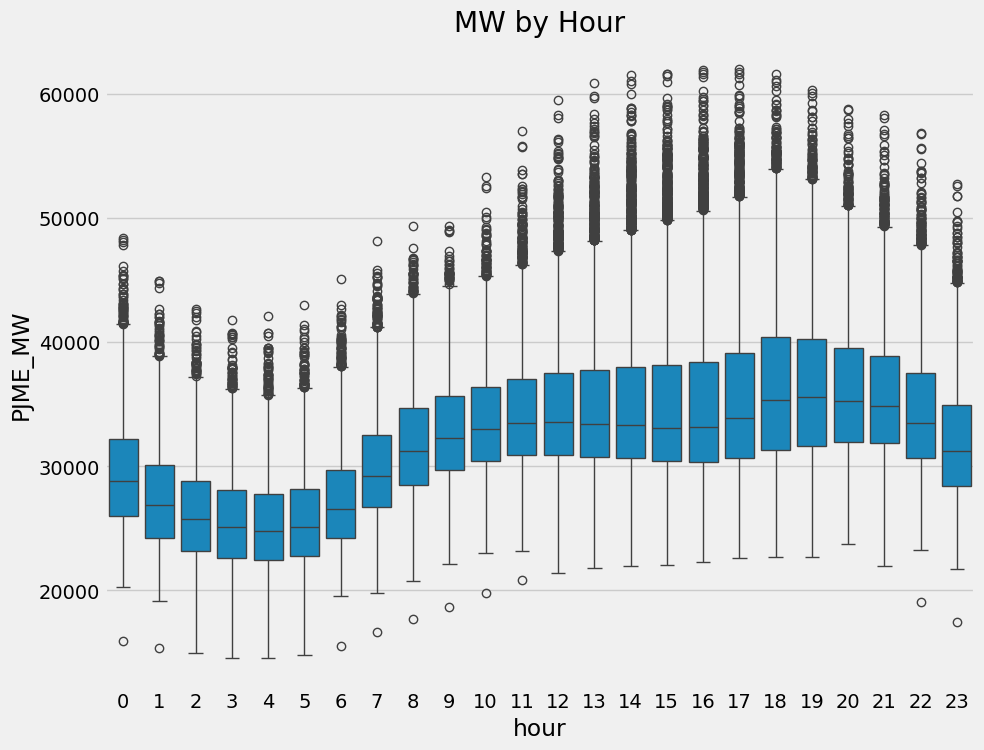

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data = df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-34-69cf918e87c9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


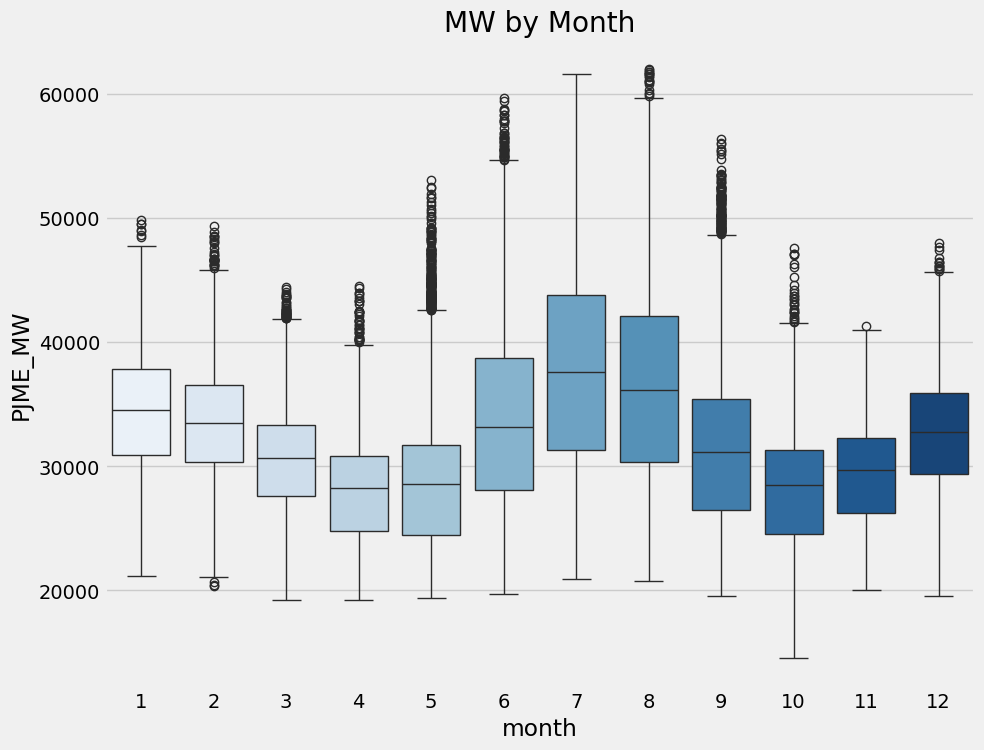

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Create our Model


In [40]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [41]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13856	validation_1-rmse:31657.12967


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:51:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35183	validation_1-rmse:11747.19029
[200]	validation_0-rmse:5836.65706	validation_1-rmse:5362.98111
[300]	validation_0-rmse:3924.15094	validation_1-rmse:4020.64996
[400]	validation_0-rmse:3447.72512	validation_1-rmse:3859.06602
[500]	validation_0-rmse:3288.04843	validation_1-rmse:3815.34991
[600]	validation_0-rmse:3205.75532	validation_1-rmse:3777.75290
[700]	validation_0-rmse:3152.30438	validation_1-rmse:3751.38275
[800]	validation_0-rmse:3113.06070	validation_1-rmse:3735.21758
[900]	validation_0-rmse:3083.72135	validation_1-rmse:3726.32641
[999]	validation_0-rmse:3057.44231	validation_1-rmse:3722.95131


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

In [42]:
reg.feature_importances_

array([0.1363573 , 0.3423359 , 0.1771762 , 0.0641631 , 0.2540393 ,
       0.02592819], dtype=float32)

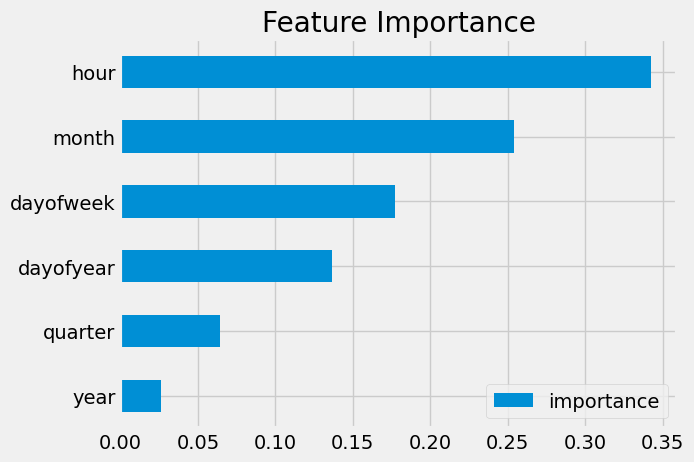

In [43]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Apply the model on test set

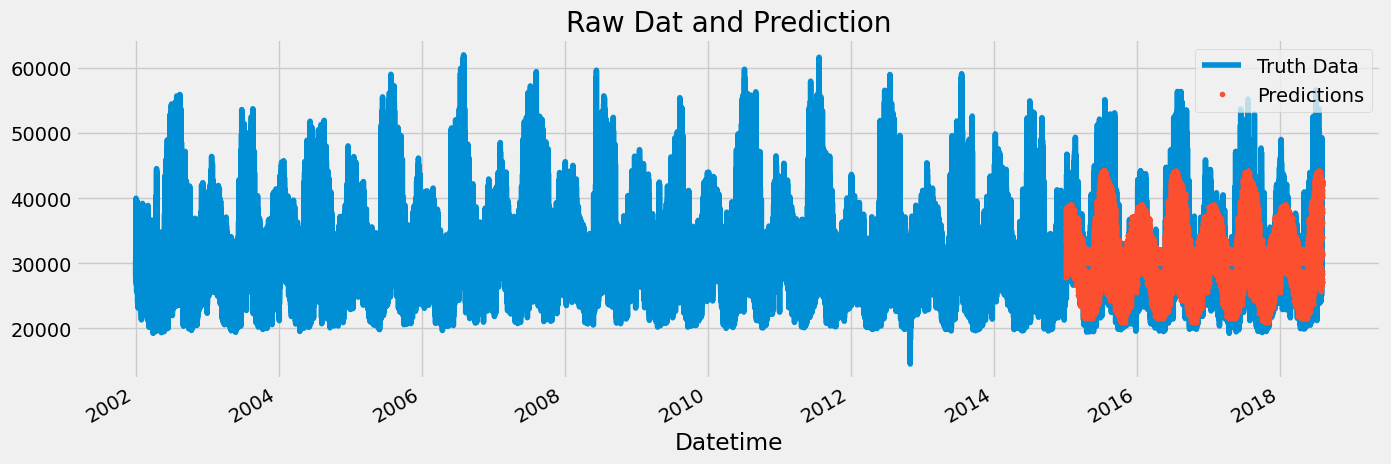

In [46]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## worst and best predicted days

In [47]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12939.784180
2016-08-14    12839.183350
2015-02-20    11151.506348
2016-09-09    11016.556152
2016-09-10    10951.222982
2018-01-06    10599.224365
2016-08-12    10119.162760
2015-02-21     9940.848551
2015-02-16     9889.071696
2018-01-07     9829.294840
Name: error, dtype: float64

In [48]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(3)

date
2017-10-24    336.785319
2015-10-28    403.131510
2016-10-27    535.349447
Name: error, dtype: float64